# Assignment 1 - Image Deblurring

Name: Brian Schweigler<br>
Matriculation number: 16-102-071

In [84]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from hessian_matrix import hessian_matrix

## Test Image

You can use the following function to create a synthetic image:



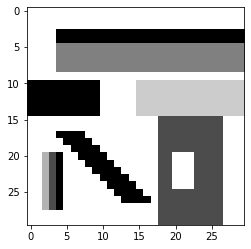

In [85]:
def create_random_binary_img_1():
    
    u = np.random.randint(1,2, 30*30).reshape(30,30).astype(float)

    u[5:9,4:] = 0.5
    u[3:5,4:] = 0
    u[10:15,:10] = 0
    u[10:15,15:] = 0.8
    u[15:, 18:27] = 0.3

    for i in range(10):
        u[i+17,i+4:i+8]  = 0
    
    u[20:25:, 20:23] = 1    
    u[20:28,4] = 0
    u[20:28,3] = 0.3
    u[20:28,2] = 0.7

    return u

sample_image = create_random_binary_img_1()

plt.imshow(sample_image, cmap ="gray")
plt.show()

## hessian_matrix() function

We provide the implementation of the hessian matrix for $k = 0, 1, 2, 3$.

input variables: 
- u: your image
- reg: regularization parameter
- k: one of the four kernel types 0-3 

Example usage:

In [86]:
u_ex = np.zeros(9).reshape(3,3)
reg_ex = 1
k_type_ex = 3
A = hessian_matrix(u_ex, reg_ex, k_type_ex)
A_n_t = A.toarray()
print(A_n_t)

[[ 4.  -2.   0.  -2.   0.   0.   0.   0.   0. ]
 [-2.   6.5 -2.   0.5 -2.   0.   0.   0.   0. ]
 [ 0.  -2.   4.5  0.   0.5 -2.   0.   0.   0. ]
 [-2.   0.5  0.   6.5 -2.   0.  -2.   0.   0. ]
 [ 0.  -2.   0.5 -2.   9.  -2.   0.5 -2.   0. ]
 [ 0.   0.  -2.   0.  -2.   6.5  0.   0.5 -2. ]
 [ 0.   0.   0.  -2.   0.5  0.   4.5 -2.   0. ]
 [ 0.   0.   0.   0.  -2.   0.5 -2.   6.5 -2. ]
 [ 0.   0.   0.   0.   0.  -2.   0.  -2.   4. ]]


## Implementation

In [87]:
def derivative_img_term(g, u):
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x, y] = 0
            elif x == 0 and y == u.shape[1] - 1:
                result[x, y] = -g[0, y - 1] + 0.5 * u[1, y] + u[0, y]
            elif x == u.shape[0] - 1 and y == 0:
                result[x, y] = 0
            elif x == u.shape[0] - 1 and y == u.shape[1] - 1:
                result[x, y] = - g[x - 1, y - 1] + 0.5 * u[x, y] + 0.5 * u[x - 1, y]
            # Edges
            elif x == 0:  # Upper edge
                result[x, y] = - g[0, y - 1] + 0.5 * u[0, y] + 0.5 * u[1, y]
            elif x == u.shape[0] - 1:  # Lower edge
                result[x, y] = - g[x - 1, y - 1] + 0.5 * u[x, y] + 0.5 * u[x - 1, y]
            elif y == 0:  # Left edge
                result[x, y] = 0
            elif y == u.shape[1] - 1:  # Right edge
                result[x, y] = - g[x, y - 1] - g[x - 1, y - 1] + u[x, y] + 0.5 * u[x + 1, y] + 0.5 * u[x - 1, y]
            # Inside Image
            else:
                result[x, y] = u[x, y] + 0.5 * u[x + 1, y] + 0.5 * u[x - 1, y] - g[x, y - 1] - g[x - 1, y - 1]
    return result


def derivative_gp_reg_term(u):
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x, y] = 4 * u[0, 0] - 2 * u[1, 0] - 2 * u[0, 1]
            elif x == 0 and y == u.shape[1] - 1:
                result[x, y] = 4 * u[0, y] - 2 * u[1, y] - 2 * u[0, y - 1]
            elif x == u.shape[0] - 1 and y == 0:
                result[x, y] = 4 * u[x, 0] - 2 * u[x - 1, 0] - u[x, 1]
            elif x == u.shape[0] - 1 and y == u.shape[1] - 1:
                result[x, y] = 4 * u[x, y] - u[x - 1, y] - u[x, y - 1]
            # Edges
            elif x == 0:  # Upper edge
                result[x, y] = 6 * u[0, y] - 2 * u[1, y] - 2 * u[0, y + 1] - 2 * u[0, y - 1]
            elif x == u.shape[0] - 1:  # Lower edge
                result[x, y] = 6 * u[x, y] - 2 * u[x - 1, y] - 2 * u[x, y + 1] - 2 * u[x, y - 1]
            elif y == 0:  # Left edge
                result[x, y] = 6 * u[x, 0] - 2 * u[x - 1, 0] - 2 * u[x + 1, 0] - 2 * u[x, 1]
            elif y == u.shape[1] - 1:  # Right edge
                result[x, y] = 6 * u[x, y] - 2 * u[x - 1, y] - 2 * u[x + 1, y] - 2 * u[x, y - 1]
            # Inside Image
            else:
                result[x, y] = 8 * u[x, y] - 2 * u[x - 1, y] - 2 * u[x + 1, y] - 2 * u[x, y + 1] - 2 * u[x, y - 1]
    return result


def derivative_atv_reg_term(u):
    result = np.zeros(u.shape)
    for x in range(u.shape[0]):
        for y in range(u.shape[1]):
            # Corners
            if x == 0 and y == 0:
                result[x, y] = - np.sign(u[1, 0] - u[0, 0]) - np.sign(u[0, 1] - u[0, 0])
            elif x == 0 and y == u.shape[1]-1:
                result[x, y] = np.sign(u[0, y] - u[0, y - 1]) - np.sign(u[1, y] - u[0, y])
            elif x == u.shape[0]-1 and y == 0:
                result[x, y] = np.sign(u[x, 0] - u[x-1, 0]) - np.sign(u[x, 1] - u[x, 0])
            elif x == u.shape[0]-1 and y == u.shape[1]-1:
                result[x, y] = np.sign(u[x, y] - u[x, y-1]) + np.sign(u[x, y] - u[x-1, y])
            # Edges
            elif x == 0: # Upper edge
                result[x, y] = - np.sign(u[1, y] - u[0, y]) - np.sign(u[0, y+1] - u[0, y]) - np.sign(u[0, y] - u[0, y-1])
            elif x == u.shape[0]-1: # Lower edge
                result[x, y] = np.sign(u[x, y] - u[x-1, y]) + np.sign(u[x, y] - u[x, y-1]) - np.sign(u[x, y+1] - u[x, y])
            elif  y == 0: # Left edge
                result[x, y] = - np.sign(u[x+1, 0] - u[x, 0]) + np.sign(u[x, 0] - u[x-1, 0]) - np.sign(u[x, 1] - u[x, 0])
            elif y == u.shape[1]-1: # Right edge
                result[x, y] = np.sign(u[x, y] - u[x, y-1]) + np.sign(u[x, y] - u[x-1, y]) - np.sign(u[x+1, y] - u[x, y])
            # Inside Image
            else:
                result[x, y] = np.sign(u[x, y] - u[x - 1, y]) - np.sign(u[x + 1, y] - u[x, y]) - np.sign(
                    u[x, y + 1] - u[x, y]) - np.sign(u[x, y] - u[x, y - 1])
    return result

def GD(g, reg_lambda=0.01):
    """
    Gradient Descent algorithm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    """
    # TODO Test
    u = np.zeros((g.shape[0] + 1, g.shape[1] + 1))
    epsilon = 0.1

    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            u[x, y] = g[x, y]

    for i in range(1000):  #TODO Higher or lower
        # u = u - epsilon * derivative_img_term(g, u)
        # u = u - epsilon * (derivative_img_term(g, u) + reg_lambda * derivative_gp_reg_term(u))
        u = u - epsilon * (derivative_img_term(g, u) + reg_lambda * derivative_atv_reg_term(u))
    return u

In [88]:
def LGS(g, reg_lambda):
    """
    Linearalized Gauss Seidel Algortihm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    """
    u = g  # TODO: replace with actual implementation
    return u

In [89]:
def LSOR(g, reg_lambda, w):
    """
    Linearized SOR Algorithm
    g: grayscale blurry image of size (M, N)
    reg_lambda: regularization parameter
    w: SOR parameter
    """
    u = g  # TODO: replace with actual implementation


### Parameters

In [90]:
# TODO Adjust
reg_lambda = 0.0066 # lambda regularization parameter. you need to play with this
# k matrix. Look below how to choose it 
k = 1


$k =0 \longrightarrow \begin{bmatrix}\frac{1}{2} & \frac{1}{2} \\0&0\end{bmatrix} \hspace{1cm} k =1 \longrightarrow  \begin{bmatrix}\frac{1}{2} & 0 \\\frac{1}{2}&0\end{bmatrix} \hspace{1cm} k =2 \longrightarrow \begin{bmatrix}\frac{1}{2} & 0 \\0&\frac{1}{2}\end{bmatrix}   \hspace{1cm} k =3 \longrightarrow \begin{bmatrix}0 & \frac{1}{2} \\ \frac{1}{2}&0\end{bmatrix}$


### Blurring the image

In [91]:
def blurring(img, kernel):
    blurred_img = np.zeros((img.shape[0] - 1, img.shape[1] - 1))
    for row in range(img.shape[0] - 1):
        for column in range(img.shape[1] - 1):
            blur_pixel = 0
            for p in range(kernel.shape[0]):
                for q in range(kernel.shape[1]):
                    blur_pixel += kernel[p, q] * img[row - p + 1, column - q + 1]
                blurred_img[row, column] = blur_pixel
    return blurred_img

### Reading image

You are provided with only the synthetic image. 
The purpose of using a synthetic image is to see possible changes in the deblurred image after applying your algorithm. 
You can convolve the original image using the [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).
Note that you must choose **valid** as the mode in your convolution.

In [92]:
img_org = sample_image = create_random_binary_img_1()

# Kernel k = 1
kernel = np.array([[0.5,0],[0.5,0]])

# TODO: blur this image
img_blurred = blurring(sample_image, kernel)

## GRADIENT DESCENT

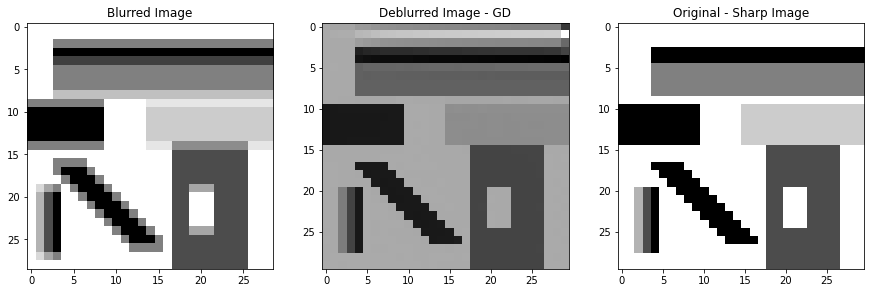

For lambda 0.00660	 
k_type 1
Loss Data Term = 
Sum of Squared Distance: deblurred vs. original = 


In [93]:
# run gradient descent algorithm
img_deblurred_gd = GD(img_blurred, reg_lambda)

# for visualization purpose 
# img_deblurred_gd = np.clip(u_final_gd, 0, 1)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gd, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - GD")
ax3.set_title("Original - Sharp Image")
plt.show()

print(f"For lambda {reg_lambda:.5f}\t \nk_type {k:1d}")

# TODO: print the loss
print(f"Loss Data Term = ")

# TODO: print the error
print("Sum of Squared Distance: deblurred vs. original = ")  

## SOR

TypeError: Image data of dtype object cannot be converted to float

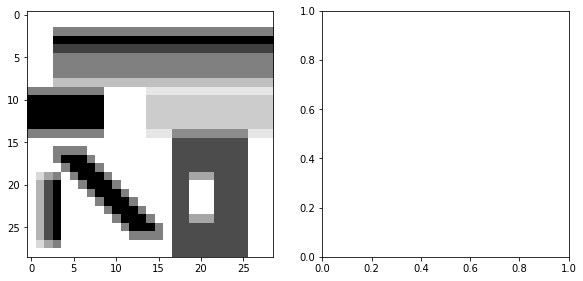

In [94]:
w = 0.3 #play with this

# run LSOR algorithm
img_deblurred_sor = LSOR(img_blurred, reg_lambda, w)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_sor, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org,cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LSOR")
ax3.set_title("Original - Sharp Image")
#plt.savefig("results_"+str(k)+".png")
plt.show()

print(f"For lambda {reg_lambda:.5f}")

# TODO: print the loss
print(f"Loss Data Term = ")

# TODO: print the error
print("Sum of Squared Distance: deblurred vs. original = ")  

### Miscellanous functions

In [ ]:
def compute_loss(deblurred):
    loss = 0
    for x in range(deblurred.shape[0] - 1):
        for y in range(deblurred.shape[1] - 1):
            pass  #TODO, no?
    return loss


def compute_diff(original, deblurred):
    diff = 0
    for x in range(deblurred.shape[0] - 1):
        for y in range(deblurred.shape[1] - 1):
            diff += np.sqrt((original[x, y] - deblurred[x, y]) ** 2)
    return diff

## GAUSS - SEIDEL

In [ ]:
nb_iter = 1

# run LGS algorithm
img_deblurred_gs = LGS(img_blurred, reg_lambda)


plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 3, 1)
plt.imshow(img_blurred, cmap='gray')
ax2 = plt.subplot(1, 3, 2)
plt.imshow(img_deblurred_gs, cmap='gray')
ax3 = plt.subplot(1, 3, 3)
plt.imshow(img_org, cmap='gray')

ax1.set_title("Blurred Image")
ax2.set_title("Deblurred Image - LGS")
ax3.set_title("Original - Sharp Image")
plt.show()

print(f"For lambda {reg_lambda:.5f}")

# TODO: print the loss
print(f"Loss Data Term = {compute_loss(img_deblurred_gd)}")

# TODO: print the error
print(f"Sum of Squared Distance: deblurred vs. original = {compute_diff(sample_image,img_deblurred_gd)}")